In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pdb
import scipy.special as scpspc

In [2]:
import numpy as np
import pdb
import sys
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
from tomplot import (extract_gusto_field, extract_gusto_coords,             
                        regrid_horizontal_slice)


def make_structured(filepath, field_name):

    # f1, dumpfreq = filepath.split('df')
    # f2, dt = f1.split('dt')

    results_dir = f'/data/home/sh1293/results/jupiter_sw/{filepath}'
    results_file_name = f'{results_dir}/field_output.nc'
    data_file = Dataset(results_file_name, 'r')
    times = np.array(data_file['time'])
    field_data = extract_gusto_field(data_file, field_name)
    coords_X, coords_Y = extract_gusto_coords(data_file, field_name)

    tol = 1e-6
    unique_X = [coords_X[0]]
    unique_Y = [coords_Y[0]]
    for x in coords_X:
        if np.min(abs(x-unique_X)) > tol:
            unique_X.append(x)
    for y in coords_Y:
        if np.min(abs(y-unique_Y)) > tol:
            unique_Y.append(y)
    unique_X = np.array(np.sort(unique_X))
    unique_Y = np.array(np.sort(unique_Y))
    X, Y = np.meshgrid(unique_X, unique_Y)

    new_data = regrid_horizontal_slice(X, Y,
                                            coords_X, coords_Y, field_data)
    da_2d = xr.DataArray(data=new_data,
                    dims=['y', 'x', 'time'],
                    coords=dict(y=unique_Y, x=unique_X, time=times),
                    name=field_name)

    return da_2d, times

In [3]:
filepath = 'new_single_fplane_Bu2b1p5Rop2_l5dt250df1'

In [4]:
pv, _ = make_structured(filepath, 'PotentialVorticity')

/tmp/ipykernel_3462755/1844630301.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  times = np.array(data_file['time'])


In [6]:
rv, _ = make_structured(filepath, 'RelativeVorticity')

/tmp/ipykernel_3253682/1844630301.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  times = np.array(data_file['time'])


In [7]:
Bu = float(filepath.split('Bu')[1].split('b')[0])
try:
    bi = float(filepath.split('b')[1].split('p')[0])
    bd = float(filepath.split('b')[1].split('Ro')[0].split('p')[1])*10**-len(filepath.split('b')[1].split('Ro')[0].split('p')[1])
    b = bi+bd
except ValueError:
    b = float(filepath.split('b')[1].split('Ro')[0])
Ro = float(filepath.split('Rop')[1].split('_')[0])*10**-len(filepath.split('Rop')[1].split('_')[0])

g = 24.79
Omega = 1.74e-4
R = 71.4e6
f0 = 2 * Omega        # Planetary vorticity
rm = 1e6              # Radius of vortex (m)
vm = Ro * f0 * rm     # Calculate speed with Ro
phi0 = Bu * (f0*rm)**2
H = phi0/g
t_day = 2*np.pi/Omega

In [8]:
D, _ = make_structured(filepath, 'D')

/tmp/ipykernel_3253682/1844630301.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  times = np.array(data_file['time'])


In [5]:
def analytic_pv(x, xpole):
    r = abs(x-xpole)*1e3
    num = 1+Ro*(2-(r/rm)**b)*np.exp(1/b*(1-(r/rm)**b))
    dem = 1-Ro/Bu*np.exp(1/b)*b**(2/b-1)*scpspc.gammaincc(2/b, 1/b*(r/rm)**b)*scpspc.gamma(2/b)
    pv = f0/H*num/dem
    return pv

In [8]:
pv0 = pv.where(pv.time==0, drop=True)
ypole = np.median(pv.y)
pv0c = pv0.where(pv0.y==ypole, drop=True)
xpole = np.median(pv.x)
spacing = pv.x[-1]/len(pv.x)
pv0cc = pv0c.where(pv0c.x>=xpole-40*spacing, drop=True).where(pv0c.x<=xpole+40*spacing, drop=True)
x_centre = pv0cc.x
pva = analytic_pv(x_centre, xpole)

In [15]:
ypole

np.float64(35000.0)

In [75]:
rvpvpole = (rv[round(len(rv.y)/2), round(len(rv.x)/2), 0]+f0)/D[round(len(D.y)/2), round(len(D.x)/2), 0]
# rvpvpole = (rv[round(len(rv.y)/2), round(len(rv.x)/2), 0]+f0)/H
rvpvpole

<xarray.DataArray ()> Size: 8B
array(7.93874279e-08)
Coordinates:
    time     float64 8B 0.0

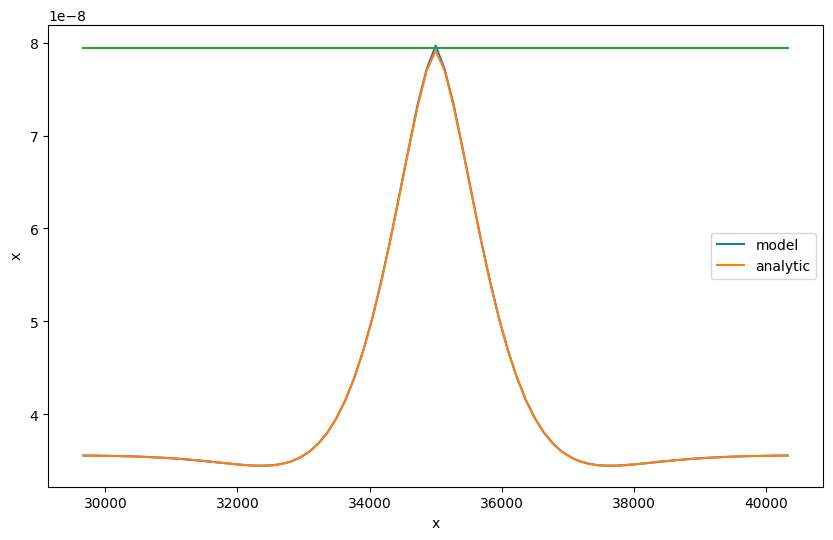

In [76]:
fig, ax = plt.subplots(1,1, figsize=(10,10/1.666))
pvplot = (pv0cc).plot(ax=ax, label='model')
aplot = (pva).plot(ax=ax, label='analytic')
rplot = plt.plot(x_centre, [rvpvpole]*len(x_centre))
plt.legend()

In [17]:
x_points = [136.71875*i for i in range(217, 296)]

In [21]:
points = [(136.71875*i, 136.71875*256) for i in range(217, 296)]

In [22]:
points

[(29667.96875, 35000.0),
 (29804.6875, 35000.0),
 (29941.40625, 35000.0),
 (30078.125, 35000.0),
 (30214.84375, 35000.0),
 (30351.5625, 35000.0),
 (30488.28125, 35000.0),
 (30625.0, 35000.0),
 (30761.71875, 35000.0),
 (30898.4375, 35000.0),
 (31035.15625, 35000.0),
 (31171.875, 35000.0),
 (31308.59375, 35000.0),
 (31445.3125, 35000.0),
 (31582.03125, 35000.0),
 (31718.75, 35000.0),
 (31855.46875, 35000.0),
 (31992.1875, 35000.0),
 (32128.90625, 35000.0),
 (32265.625, 35000.0),
 (32402.34375, 35000.0),
 (32539.0625, 35000.0),
 (32675.78125, 35000.0),
 (32812.5, 35000.0),
 (32949.21875, 35000.0),
 (33085.9375, 35000.0),
 (33222.65625, 35000.0),
 (33359.375, 35000.0),
 (33496.09375, 35000.0),
 (33632.8125, 35000.0),
 (33769.53125, 35000.0),
 (33906.25, 35000.0),
 (34042.96875, 35000.0),
 (34179.6875, 35000.0),
 (34316.40625, 35000.0),
 (34453.125, 35000.0),
 (34589.84375, 35000.0),
 (34726.5625, 35000.0),
 (34863.28125, 35000.0),
 (35000.0, 35000.0),
 (35136.71875, 35000.0),
 (35273.4375,